# Title Here
Brian Beardsall, Aaron Judah, Shannon Myles  
December 9, 2020

# Setup

In [135]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp 
import random as rd
import pymc3 as pm
import theano as Th
import theano.tensor as tt
from matplotlib import pyplot as plt
import arviz as az
from IPython.display import display, Math, Latex


# Helper functions
def stdize(x):
    return (x-np.mean(x))/np.std(x)


def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

## Reading and processing of data

In [137]:
data = pd.read_csv('data/processedData.csv')
data.head()

,FIPS,county,state,volatility,governanceScore,margin2016,margin2020,bidenSwing,casesPerCap,propWhite
0,1001,Autauga County,Alabama,0.769673,-1.0,-49.0,-44.41844,4.58156,0.037101,0.768786
1,1003,Baldwin County,Alabama,0.732929,-1.0,-57.2,-53.76234,3.43766,0.031892,0.862662
2,1005,Barbour County,Alabama,0.926327,-1.0,-5.6,-7.66305,-2.06305,0.039989,0.473819
3,1007,Bibb County,Alabama,1.943771,-1.0,-55.2,-57.72798,-2.52798,0.036756,0.766547
4,1009,Blount County,Alabama,2.486867,-1.0,-80.9,-80.00217,0.89783,0.033394,0.955052


Extract data as numpy arrays.

In [138]:
FIPS = data['FIPS']
nFIPS = len(FIPS)
CP = data['casesPerCap']
V = data['volatility']
SW = data['bidenSwing']
W = data['propWhite']
P = data['margin2016']
sData = data['state']
cData = data['FIPS']

In [139]:
# Grouping by state to get governance for each state.
grouped_df = data.groupby("state")
first_values = grouped_df.first()
G = first_values['governanceScore']
State, Is = indexall(sData)
County, Ic = indexall(cData)

Looking at the distributions of processedData.csv

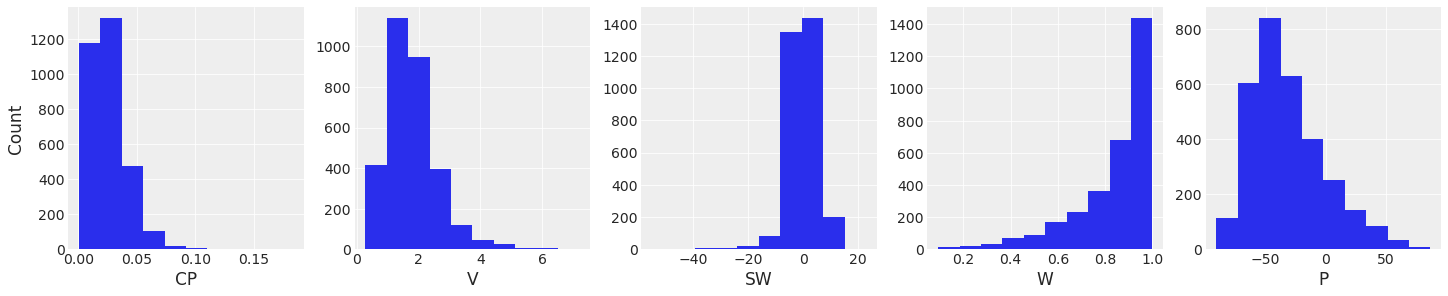

In [140]:
_, ax = plt.subplots(1,5, figsize=(20,4))

ax[0].hist(CP)
ax[0].set_xlabel('CP', fontsize=17)
ax[0].set_ylabel('Count', fontsize=17)

ax[1].hist(V)
ax[1].set_xlabel('V', fontsize=17)

ax[2].hist(SW)
ax[2].set_xlabel('SW', fontsize=17)

ax[3].hist(W)
ax[3].set_xlabel('W', fontsize=17)

ax[4].hist(P)
ax[4].set_xlabel('P', fontsize=17)
plt.show()

Some more data processing.

In [185]:
# Log transform cases per capita
logCP = np.log(CP)

# Standardize all covariates except governance and minority proportion
logCP = stdize(logCP)
V = stdize(V)
SW = stdize(SW)
P = stdize(P)

M = 1-W

Plot distributions of processed data.

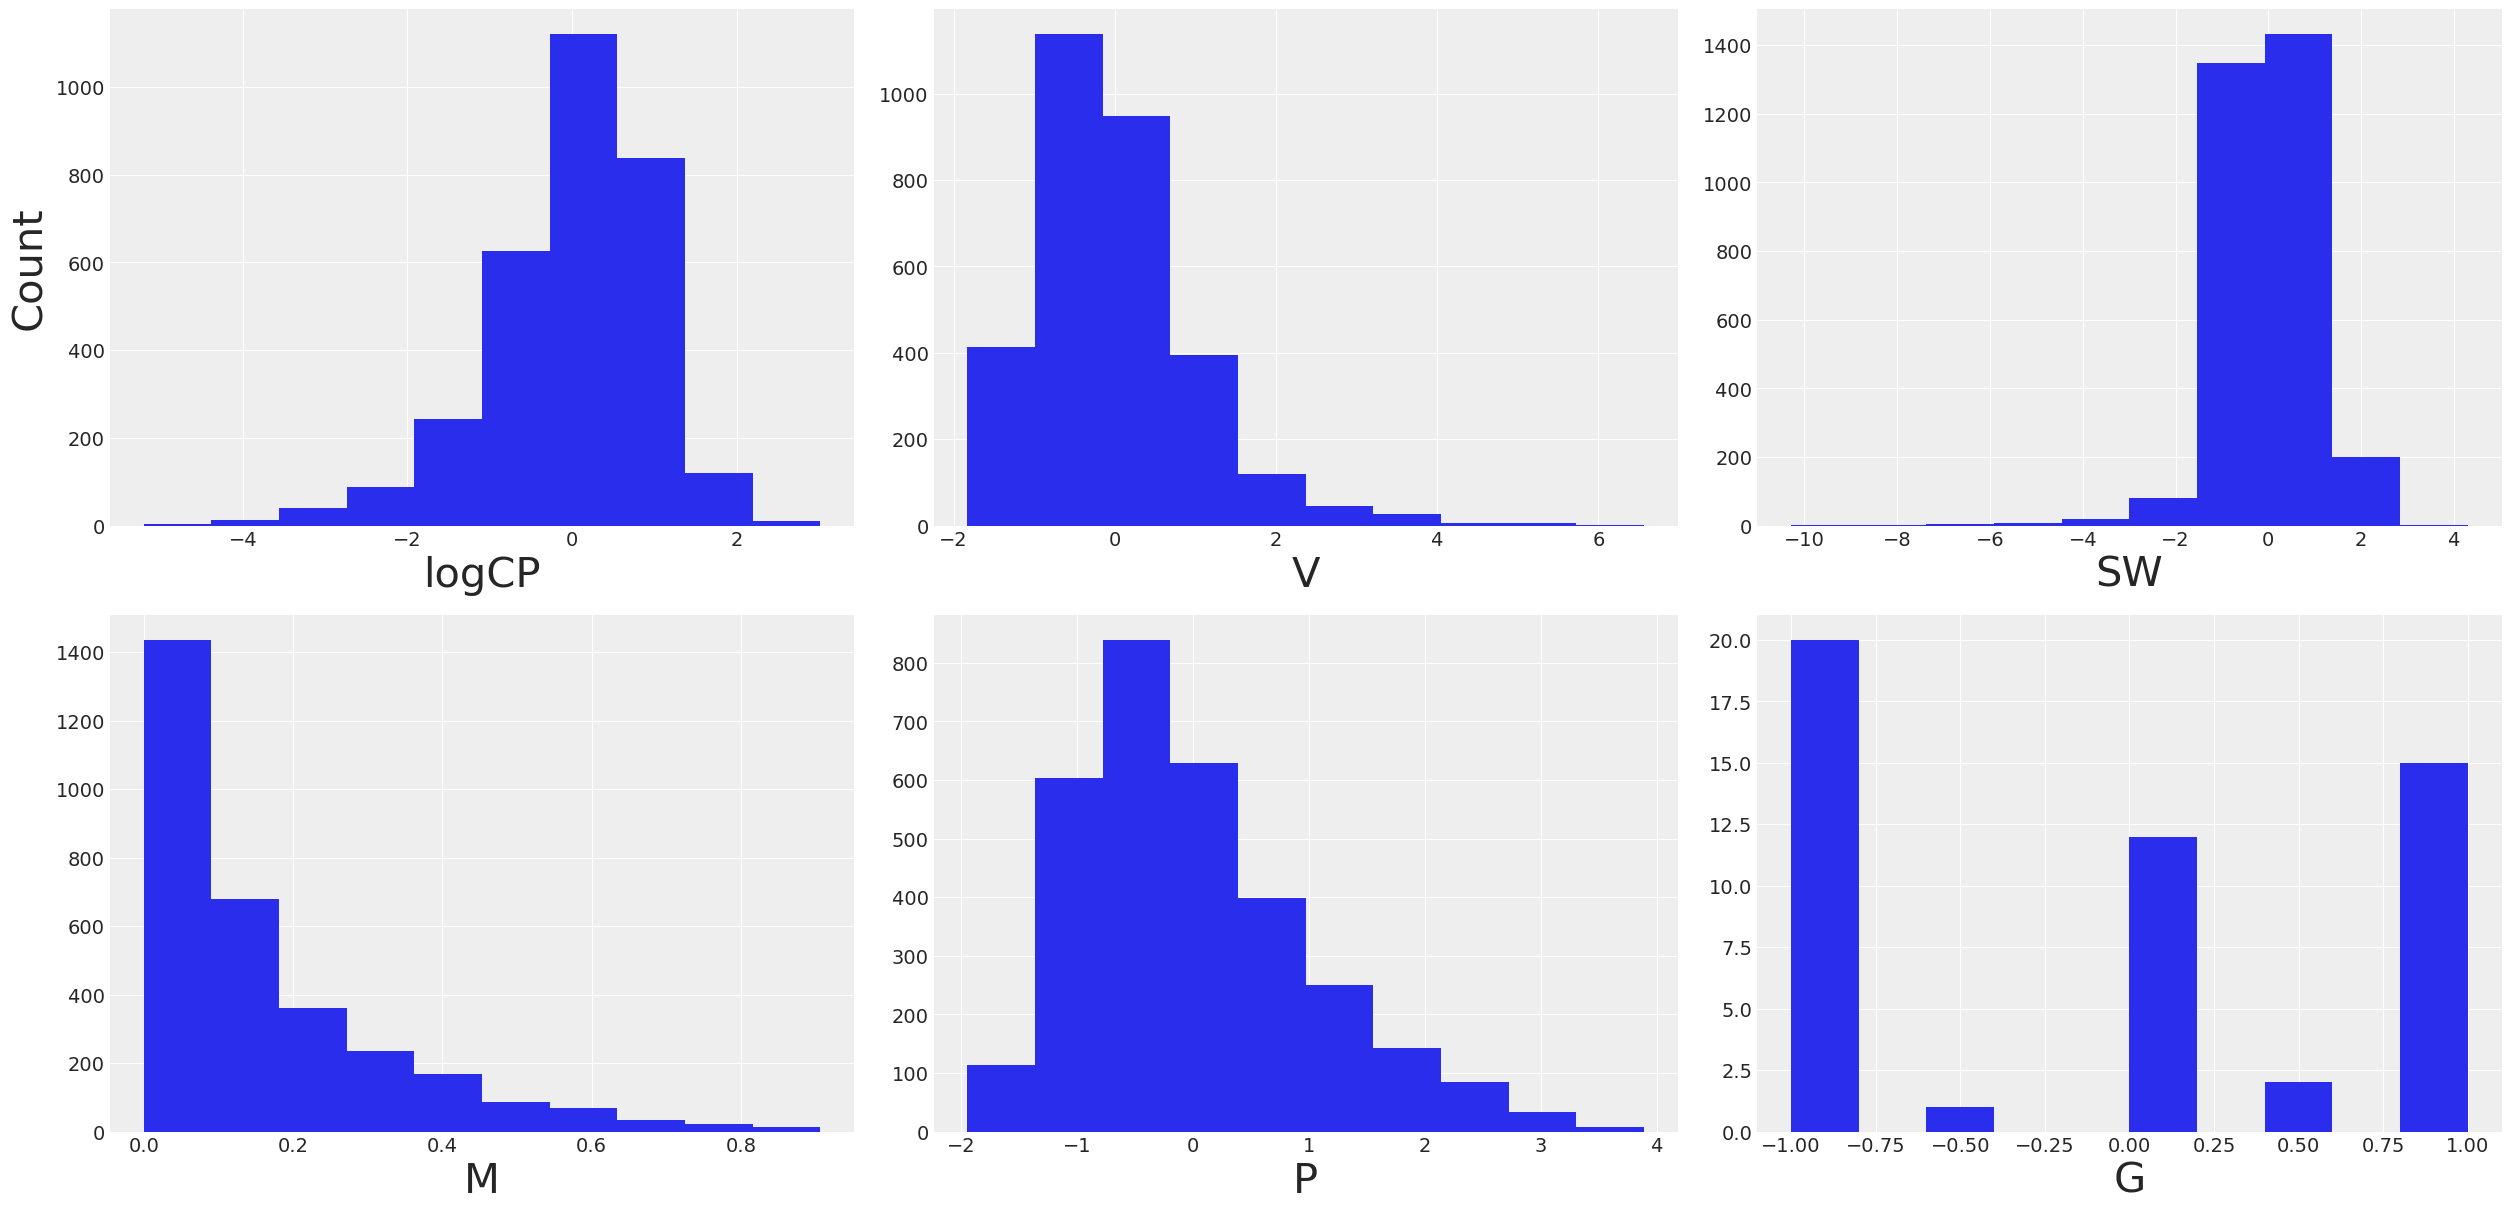

In [231]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(25,12))

ax[0][0].hist(logCP)
ax[0][0].set_xlabel('logCP', fontsize=30)
ax[0][0].set_ylabel('Count', fontsize=30)

ax[0][1].hist(V)
ax[0][1].set_xlabel('V', fontsize=30)

ax[0][2].hist(SW)
ax[0][2].set_xlabel('SW', fontsize=30)

ax[1][0].hist(M)
ax[1][0].set_xlabel('M', fontsize=30)

ax[1][1].hist(P)
ax[1][1].set_xlabel('P', fontsize=30)

ax[1][2].hist(G)
ax[1][2].set_xlabel('G', fontsize=30)
plt.savefig('figs/dataDistribution.png')
plt.show()


## Statistical model in Bayesian framework

$$
SW_{[c]} \sim N(\alpha_{[s]} + \beta_{CP[c]} logCP_{[c]}  + \beta_{V[c]} V_{[c]} +\beta_{M[c]} M_{[c]} + \beta_{P[c]} Pres2016_{[c]}, \sigma_{[c]})
$$

\begin{align}
\alpha_{[s]} &\sim N(\gamma_0 + \gamma_1 G_{[s]}, \sigma_{\alpha[s]}) \\
\gamma &\sim N(0, 3.5)
\end{align}

\begin{align}
\beta_{j[c]} &\sim N(\mu_j, \sigma_{\beta{j[c]}}) \\
\mu_{j} &\sim N(0, 0.4)
\end{align}

$$
\sigma_{[c]} \sim Exp(1)
$$

In [144]:
with pm.Model(coords = {'State': State, 'County': FIPS}) as hierarchical_intercept:
    # Hyperpriors for intercept
    g = pm.Normal("g", mu=0.0, sigma=3.5, shape=2)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    
    # hyperpriors for slopes
    mu_c = pm.Normal("mu_c", mu=0.0, sigma=0.4)
    sigma_c = pm.Exponential("sigma_c", 1)
    
    mu_m = pm.Normal('mu_m', 0, 0.4)
    sigma_m = pm.Exponential('sigma_m', 1)

    mu_v = pm.Normal('mu_v', 0, 0.4)
    sigma_v = pm.Exponential('sigma_v', 1)
    
    mu_p = pm.Normal('mu_p', 0, 0.4)
    sigma_p = pm.Exponential('sigma_p', 1)
    
    # Varying intercepts (state):
    mu_a = pm.Deterministic("a", g[0] + g[1] * G, dims="State")
    za_state = pm.Normal("za_state", mu=0.0, sigma=1.0, dims="State")
    a_state = pm.Deterministic("a_state", mu_a + za_state * sigma_a, dims="State")
    
    #varying slopes (county)
    zb_c = pm.Normal("zb_c", mu=0.0, sigma=0.4, dims="County")
    b_c  = pm.Deterministic("b_c", mu_c + zb_c * sigma_c, dims="County")

    zb_m = pm.Normal("zb_m", mu=0.0, sigma=0.4, dims="County")
    b_m  = pm.Deterministic("b_m", mu_m + zb_m * sigma_m, dims="County")
    
    zb_v = pm.Normal("zb_v", mu=0.0, sigma=0.4, dims="County")
    b_v  = pm.Deterministic("b_v", mu_v + zb_v * sigma_v, dims="County")
    
    zb_p = pm.Normal("zb_p", mu=0.0, sigma=0.4, dims="County")
    b_p  = pm.Deterministic("b_p", mu_p + zb_p * sigma_p, dims="County")

    # PyMC3 Data objects for plotting later
    Ic_ = pm.intX(pm.Data("Ic", Ic))
    P_ = pm.Data("P", P)
    
    
    # Expected value per county:
    theta = pm.Deterministic('theta', a_state[Is] + b_c * CP + b_m * M + b_v * V + b_p * P)
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=SW, dims = "County")

## Prior Predictive simulation

<ipython-input-224-ae522a0e9c39>:42: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


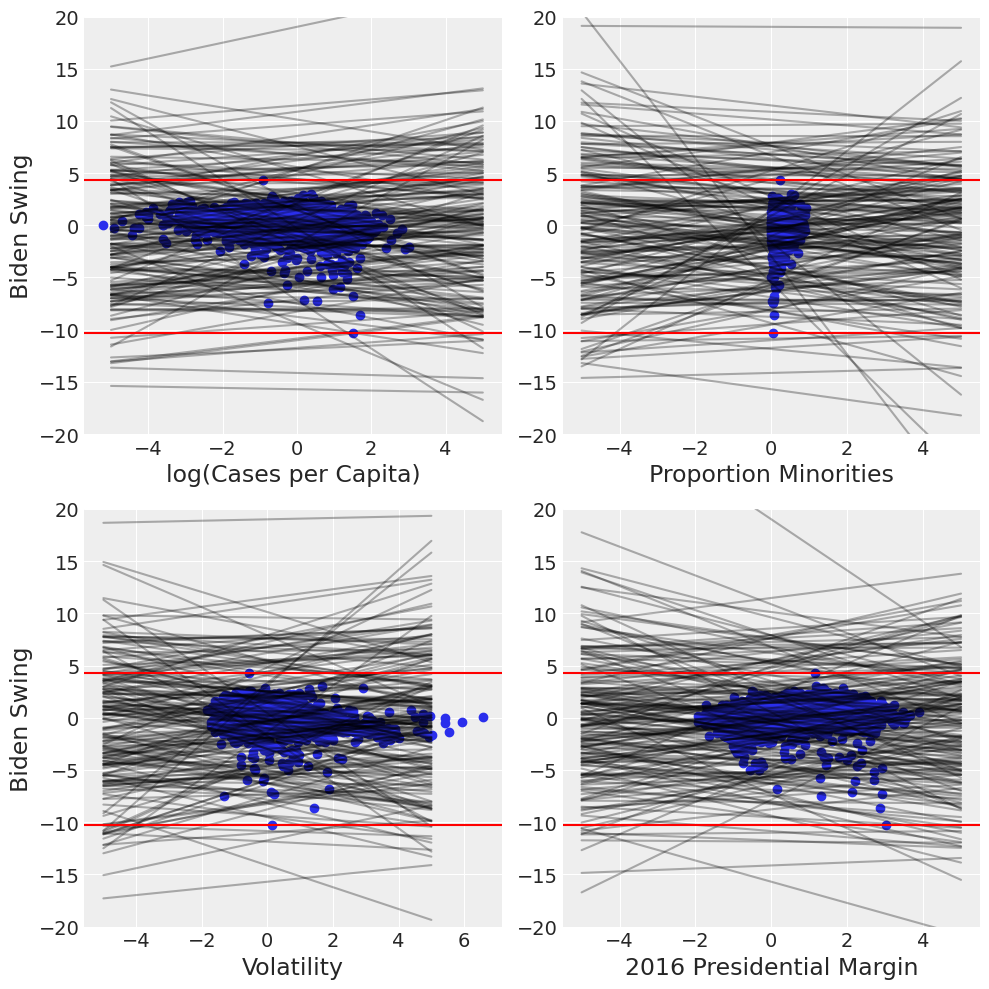

In [224]:
ppd = pm.sample_prior_predictive(200, model=hierarchical_intercept)

_, ax = plt.subplots(2,2, figsize=(10,10))
xnew = np.linspace(-5, 5, 50)

ax[0,0].scatter(logCP, SW)
[ax[0,0].plot(xnew, b0+b1*xnew, alpha=0.3, c='black') for b0,b1 in zip(ppd['a_state'].T[1], ppd['b_c'].T[1])]
#ax[0,0].set_title('logCOVID vs Biden swing', fontsize=16)
ax[0,0].axhline(np.max(SW), color='r')
ax[0,0].axhline(np.min(SW), color='r')
ax[0,0].set_ylim(-20, 20)
ax[0,0].set_xlabel('log(Cases per Capita)', fontsize=17)


ax[0,1].scatter(M, SW)
[ax[0,1].plot(xnew, b0+b1*xnew, alpha=0.3, c='black') for b0,b1 in zip(ppd['a_state'].T[1], ppd['b_m'].T[1])]
#ax[0,1].set_title('Minorities vs Biden swing', fontsize=16)
ax[0,1].axhline(np.max(SW), color='r')
ax[0,1].axhline(np.min(SW), color='r')
ax[0,1].set_ylim(-20, 20)
ax[0,1].set_xlabel('Proportion Minorities', fontsize=17)

ax[1,0].scatter(V, SW)
[ax[1,0].plot(xnew, b0+b1*xnew, alpha=0.3, c='black') for b0,b1 in zip(ppd['a_state'].T[1],ppd['b_v'].T[1])]
#ax[1,0].set_title('Volatility vs Biden swing', fontsize=16)
ax[1,0].axhline(np.max(SW), color='r')
ax[1,0].axhline(np.min(SW), color='r')
ax[1,0].set_ylim(-20, 20)
ax[1,0].set_xlabel('Volatility', fontsize=17)

ax[1,1].scatter(P, SW)
[ax[1,1].plot(xnew, b0+b1*xnew, alpha=0.3, c='black') for b0,b1 in zip(ppd['a_state'].T[1],ppd['b_p'].T[1])]
#ax[1,1].set_title('Presidential2016 vs Biden swing', fontsize=16)
ax[1,1].axhline(np.max(SW), color='r')
ax[1,1].axhline(np.min(SW), color='r')
ax[1,1].set_ylim(-20, 20)
ax[1,1].set_xlabel('2016 Presidential Margin', fontsize=17)


ax[0,0].set_ylabel('Biden Swing', fontsize=17)
ax[1,0].set_ylabel('Biden Swing', fontsize=17)
plt.tight_layout()
plt.savefig('figs/countyPrior.png')
plt.show()


## Sampling model with the data

In [146]:
with hierarchical_intercept:
    hierarchical_intercept_idata = pm.sample(1000, target_accept = 0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, zb_p, zb_v, zb_m, zb_c, za_state, sigma_p, mu_p, sigma_v, mu_v, sigma_m, mu_m, sigma_c, mu_c, sigma_a, g]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 320 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


## Effect size summaries

In [271]:
summary = pm.summary(hierarchical_intercept_idata, var_names=['g', 'mu_c', 'mu_m', 'mu_v', 'mu_p'])
summary

//mnt/D2/bbeardsall/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
g[0],0.219,0.074,0.076,0.352,0.003,0.002,750.0,750.0,748.0,1636.0,1.0
g[1],0.253,0.086,0.093,0.416,0.003,0.002,637.0,626.0,642.0,1434.0,1.0
mu_c,-0.554,0.383,-1.300,0.143,0.004,0.004,9703.0,4442.0,9626.0,2784.0,1.0
mu_m,-0.395,0.160,-0.680,-0.083,0.003,0.002,3244.0,3244.0,3257.0,3246.0,1.0
mu_v,-0.325,0.019,-0.360,-0.289,0.000,0.000,1630.0,1623.0,1642.0,3089.0,1.0
mu_p,0.144,0.026,0.095,0.193,0.000,0.000,2889.0,2889.0,2901.0,3302.0,1.0


## Trace plots

//mnt/D2/bbeardsall/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


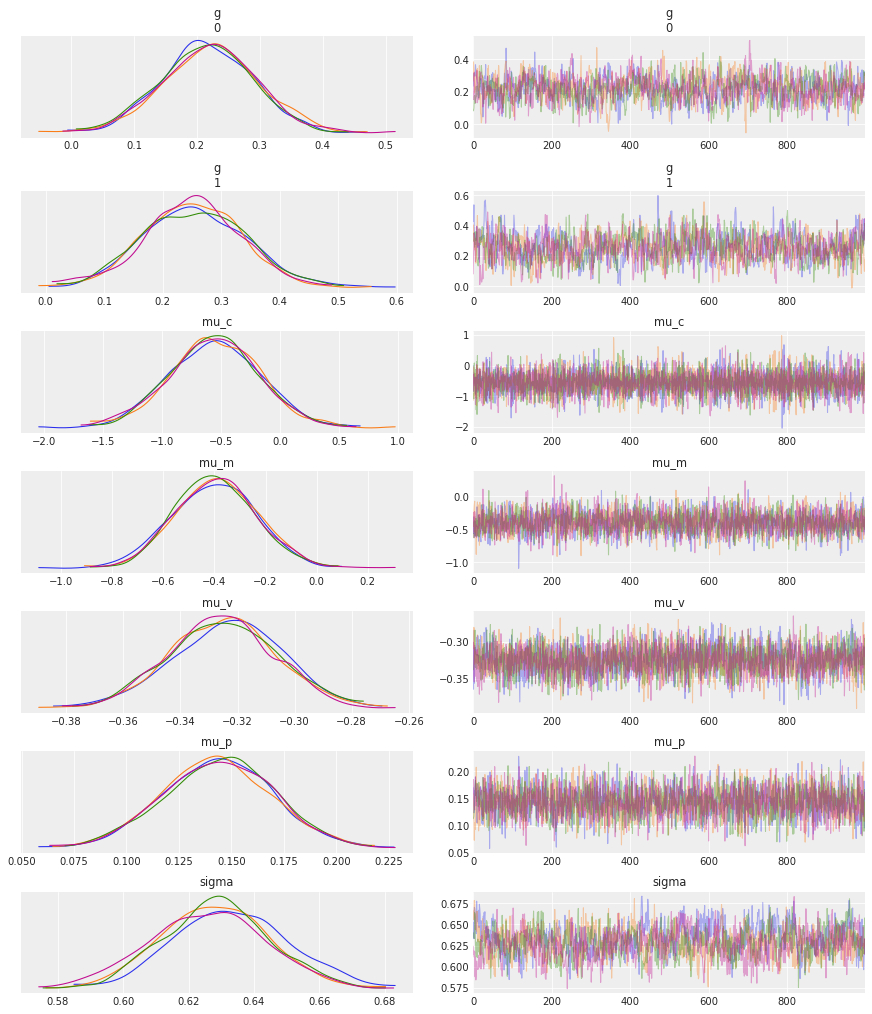

In [159]:
az.plot_trace(hierarchical_intercept_idata, var_names= ['g', 'mu_c', 'mu_m', 'mu_v', 'mu_p', 'sigma'])
plt.show()

## Posterior Plots


//mnt/D2/bbeardsall/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


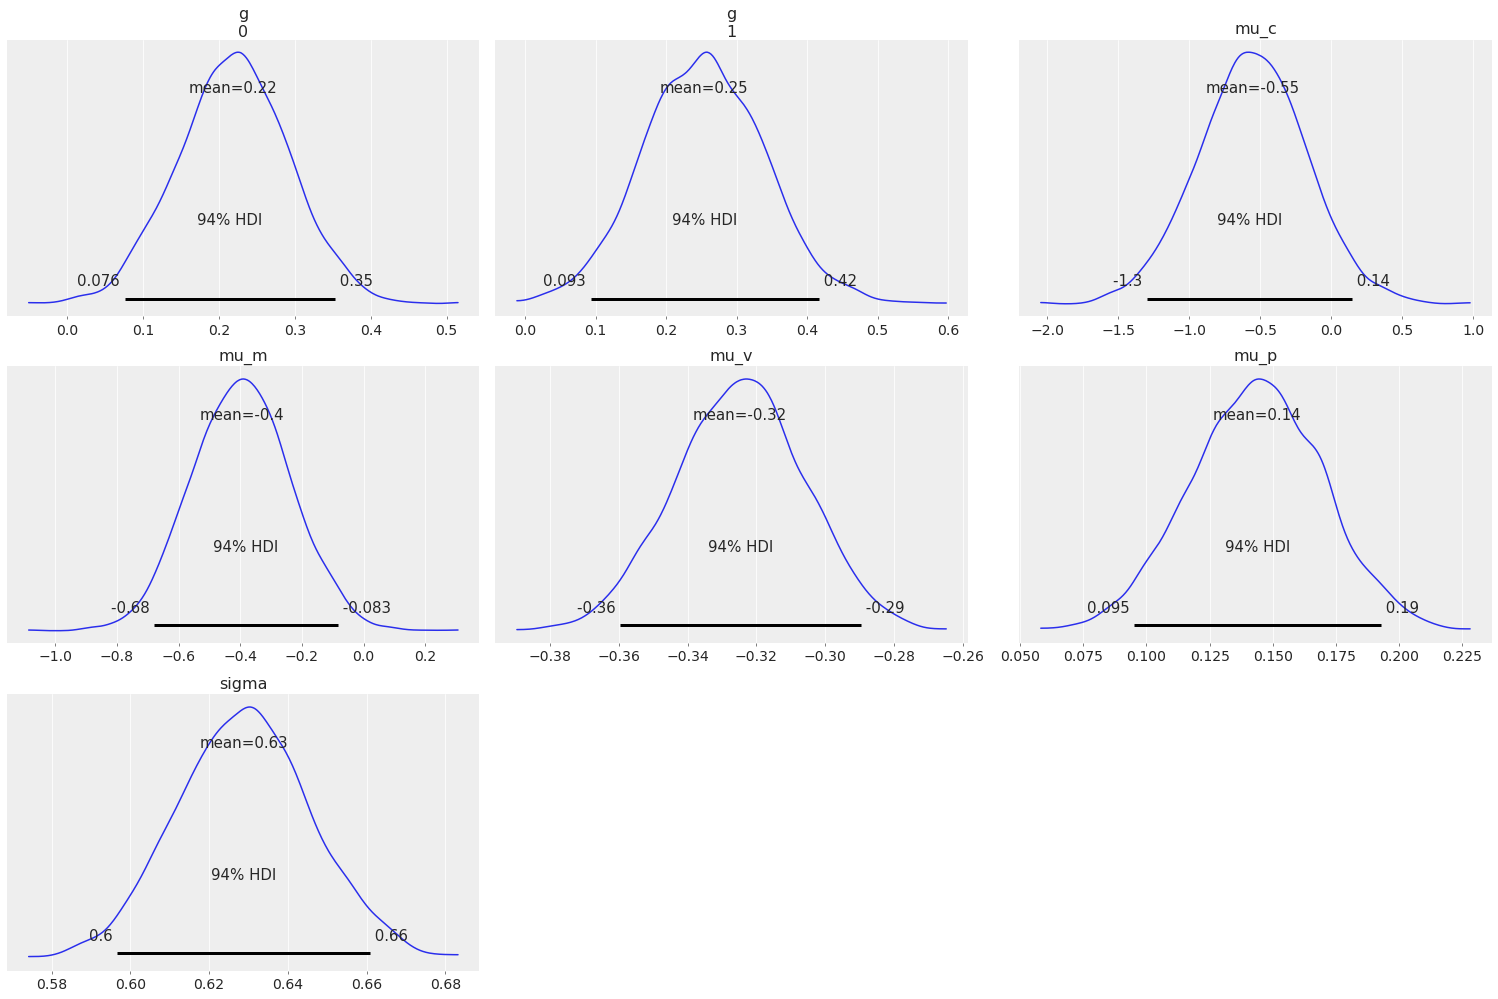

In [160]:
az.plot_posterior(hierarchical_intercept_idata, var_names= ['g', 'mu_c', 'mu_m', 'mu_v', 'mu_p', 'sigma'])
plt.show()

## Forest Plots

Bold = IQR, thin = 94% HDI

//mnt/D2/bbeardsall/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


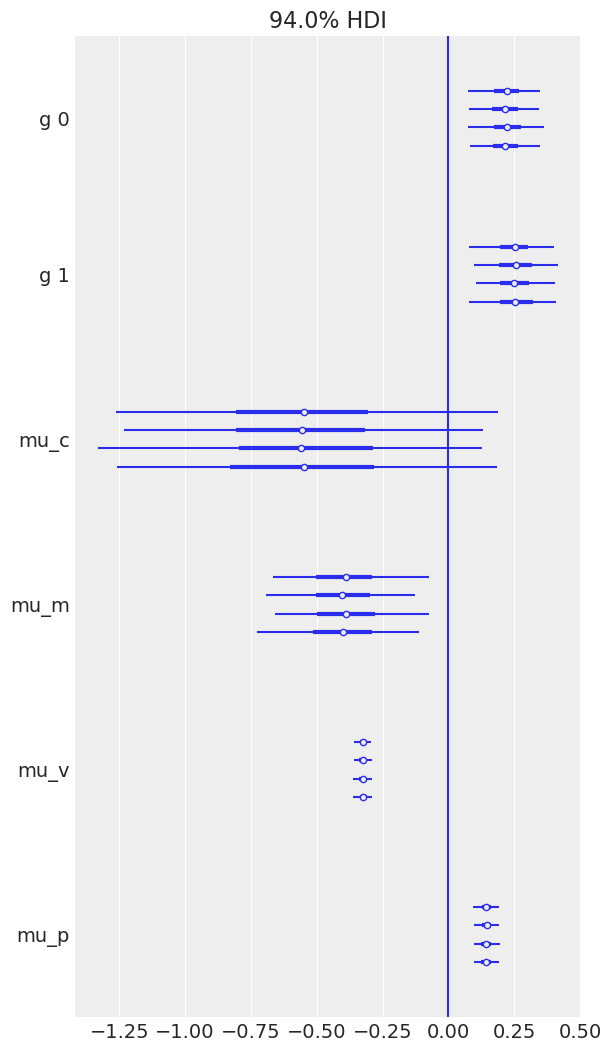

In [225]:
az.plot_forest(hierarchical_intercept_idata, var_names= ['g', 'mu_c', 'mu_m', 'mu_v', 'mu_p'])
plt.axvline(0)
plt.savefig('figs/countyForestPlot.png')
plt.show()


## Posterior predictive plot

In [162]:
PostPred = pd.DataFrame(hierarchical_intercept_idata['theta'], columns=data.FIPS)
y = PostPred.median(0).values
y_l95 = np.percentile(PostPred,2.5,axis=0)
y_u95 = np.percentile(PostPred,97.5,axis=0)
PostPredDf = pd.DataFrame([data['FIPS'], y, y_l95, y_u95, SW, logCP, M, V, P]).T
PostPredDf.columns = ['FIPS', 'pred', 'y_195', 'y_u95', 'SW', 'logCP', 'M', 'V', 'P']
PostPredDf

,FIPS,pred,y_195,y_u95,SW,logCP,M,V,P
0,1001.0,0.514700,-0.138693,1.160770,0.888595,0.803497,0.231214,-1.226654,-0.566770
1,1003.0,0.491674,-0.274069,1.232475,0.674752,0.593847,0.137338,-1.271091,-0.835841
2,1005.0,-0.021577,-0.941750,0.876872,-0.353564,0.907360,0.526181,-1.037194,0.857337
3,1007.0,-0.244242,-0.968460,0.497375,-0.440480,0.790530,0.233453,0.193308,-0.770214
4,1009.0,-0.016846,-1.001818,0.957491,0.199950,0.657611,0.044948,0.850132,-1.613522
...,...,...,...,...,...,...,...,...,...
3098,56039.0,1.454539,0.406629,2.507003,2.017677,0.608088,0.096578,1.374735,1.923777
3099,56041.0,-0.214840,-0.965172,0.552401,-0.772828,-0.000584,0.065845,-0.309413,-0.878499
3100,56043.0,-0.037594,-0.833982,0.795773,-0.389641,-0.220941,0.102842,-0.782996,-1.006471
3101,56045.0,0.040079,-0.911841,0.960671,0.021816,-0.207476,0.074648,-0.485887,-1.501956


In [273]:
PostPredDf.to_csv('data/postPredCounty.csv')

## Model over data

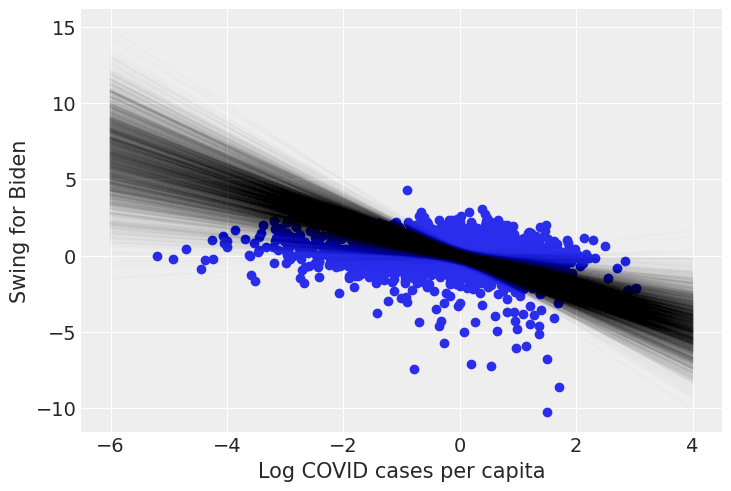

In [226]:
xnew = np.linspace(-6, 4, 100)
az.style.use("arviz-darkgrid")
plt.scatter(logCP, SW)
[plt.plot(xnew, b0+b1*xnew+b2*xnew+b3*xnew+b4*xnew, alpha=0.008, c='black') for b0,b1,b2,b3,b4 in zip(hierarchical_intercept_idata['a_state'].T[1], hierarchical_intercept_idata['mu_c'], hierarchical_intercept_idata['mu_m'], hierarchical_intercept_idata['mu_v'], hierarchical_intercept_idata['mu_p'])]
plt.xlabel("Log COVID cases per capita")
plt.ylabel("Swing for Biden")
plt.savefig('figs/countyPosteriorCovidLines.png')
plt.show()


In [274]:
# Number of values
N = 3103
# Range of positive standardized population
xnew = np.linspace(-6,4,N)

with hierarchical_intercept:
    # Low contact predictions
    pm.set_data({'Ic':np.array([0]*N), 'P':xnew})
    ynew = pm.sample_posterior_predictive(hierarchical_intercept_idata, var_names=['y'])['y']
    
# Grab trendlines
ymu = ynew.mean(0)

//mnt/D2/bbeardsall/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


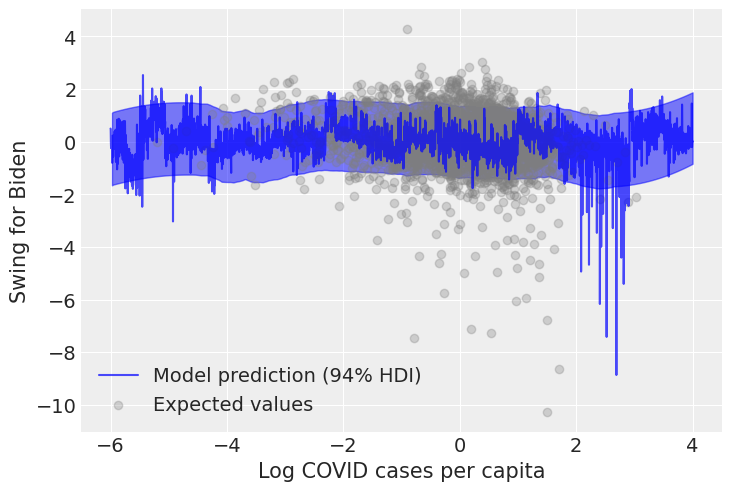

In [275]:
az.plot_hdi(xnew, ynew, color="b", fill_kwargs={"alpha": 0.5})
plt.plot(xnew, ymu, color="b", alpha=0.7, label='Model prediction (94% HDI)')
plt.scatter(logCP, SW, c='grey', alpha=0.3, label='Expected values')

az.style.use("arviz-darkgrid")
plt.xlabel("Log COVID cases per capita")
plt.ylabel("Swing for Biden")
plt.legend(loc='lower left')
plt.savefig('figs/countyPosteriorPoints.png')
plt.show()


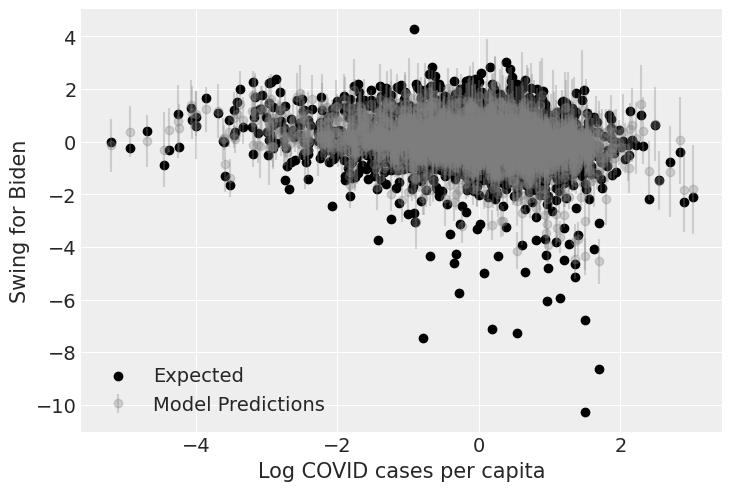

In [219]:
error = np.abs(PostPredDf.y_195 - PostPredDf.y_u95)
plt.errorbar(PostPredDf['logCP'], PostPredDf['pred'], yerr=error, c='grey', fmt='o', alpha=0.3, label='Model Predictions')
plt.scatter(PostPredDf['logCP'], PostPredDf['SW'], c='black', label='Expected')
plt.xlabel("Log COVID cases per capita")
plt.ylabel("Swing for Biden")
az.style.use('arviz-darkgrid')
plt.legend(loc='lower left')
plt.savefig('figs/countyPosteriorIndividualPoints.png')

# State Varying Slopes

In [168]:
with pm.Model(coords = {'State': State, 'County': FIPS}) as state_slopes_model:
    # Hyperpriors for intercept
    g = pm.Normal("g", mu=0.0, sigma=3.5, shape=2)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    
    # hyperpriors for slopes
    mu_c = pm.Normal("mu_c", mu=0.0, sigma=0.5)
    sigma_c = pm.Exponential("sigma_c", 1)
    
    mu_m = pm.Normal('mu_m', 0, 0.5)
    sigma_m = pm.Exponential('sigma_m', 1)

    mu_v = pm.Normal('mu_v', 0, 0.5)
    sigma_v = pm.Exponential('sigma_v', 1)
    
    mu_p = pm.Normal('mu_p', 0, 0.5)
    sigma_p = pm.Exponential('sigma_p', 1)
    
    # Varying intercepts (state):
    mu_a = pm.Deterministic("a", g[0] + g[1] * G, dims="State")
    za_state = pm.Normal("za_state", mu=0.0, sigma=1.0, dims="State")
    a_state = pm.Deterministic("a_state", mu_a + za_state * sigma_a, dims="State")
    
    #varying slopes (state)
    zb_c = pm.Normal("zb_c", mu=0.0, sigma=1, dims="State")
    b_c  = pm.Deterministic("b_c", mu_c + zb_c * sigma_c, dims="State")

    zb_m = pm.Normal("zb_m", mu=0.0, sigma=1, dims="State")
    b_m  = pm.Deterministic("b_m", mu_m + zb_m * sigma_m, dims="State")
    
    zb_v = pm.Normal("zb_v", mu=0.0, sigma=1, dims="State")
    b_v  = pm.Deterministic("b_v", mu_v + zb_v * sigma_v, dims="State")
    
    zb_p = pm.Normal("zb_p", mu=0.0, sigma=1, dims="State")
    b_p  = pm.Deterministic("b_p", mu_p + zb_p * sigma_p, dims="State")
    
    # Expected value per county:
    theta = pm.Deterministic('theta', a_state[Is] + b_c[Is] * CP + b_m[Is] * M + b_v[Is] * V + b_p[Is] * P)
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=SW, dims = "County")

## Prior Predictive simulation

<ipython-input-169-a0c59c372006>:34: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


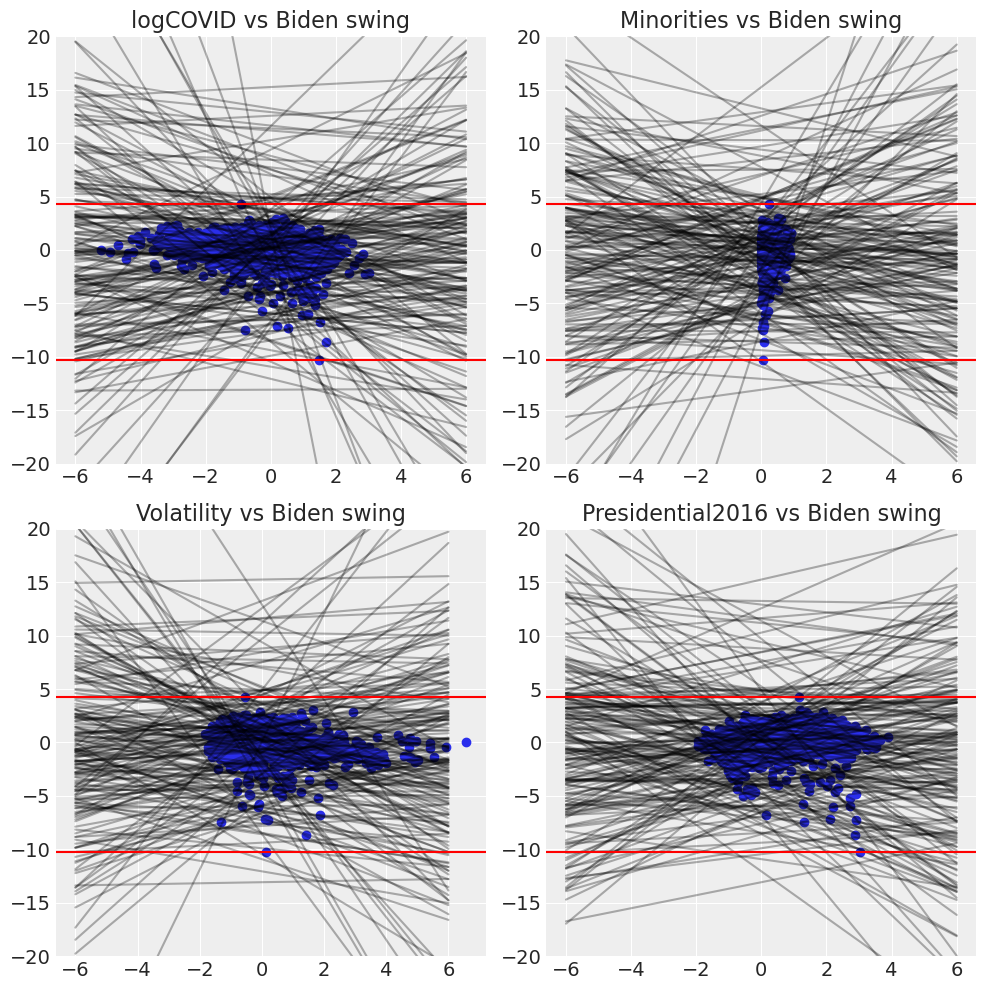

In [169]:
ppd = pm.sample_prior_predictive(200, model=state_slopes_model)

_, ax = plt.subplots(2,2, figsize=(10,10))
xnew = np.linspace(-6, 6, 50)

ax[0,0].scatter(logCP, SW)
[ax[0,0].plot(xnew, b0+b1*xnew, alpha=0.3, c='black') for b0,b1 in zip(ppd['a_state'].T[1], ppd['b_c'].T[1])]
ax[0,0].set_title('logCOVID vs Biden swing', fontsize=16)
ax[0,0].axhline(np.max(SW), color='r')
ax[0,0].axhline(np.min(SW), color='r')
ax[0,0].set_ylim(-20, 20)

ax[0,1].scatter(M, SW)
[ax[0,1].plot(xnew, b0+b1*xnew, alpha=0.3, c='black') for b0,b1 in zip(ppd['a_state'].T[1], ppd['b_m'].T[1])]
ax[0,1].set_title('Minorities vs Biden swing', fontsize=16)
ax[0,1].axhline(np.max(SW), color='r')
ax[0,1].axhline(np.min(SW), color='r')
ax[0,1].set_ylim(-20, 20)

ax[1,0].scatter(V, SW)
[ax[1,0].plot(xnew, b0+b1*xnew, alpha=0.3, c='black') for b0,b1 in zip(ppd['a_state'].T[1],ppd['b_v'].T[1])]
ax[1,0].set_title('Volatility vs Biden swing', fontsize=16)
ax[1,0].axhline(np.max(SW), color='r')
ax[1,0].axhline(np.min(SW), color='r')
ax[1,0].set_ylim(-20, 20)

ax[1,1].scatter(P, SW)
[ax[1,1].plot(xnew, b0+b1*xnew, alpha=0.3, c='black') for b0,b1 in zip(ppd['a_state'].T[1],ppd['b_p'].T[1])]
ax[1,1].set_title('Presidential2016 vs Biden swing', fontsize=16)
ax[1,1].axhline(np.max(SW), color='r')
ax[1,1].axhline(np.min(SW), color='r')
ax[1,1].set_ylim(-20, 20)

plt.tight_layout()
plt.show()

# Sample Traces

In [170]:
with state_slopes_model:
    state_slopes_trace = pm.sample(1000, target_accept = 0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, zb_p, zb_v, zb_m, zb_c, za_state, sigma_p, mu_p, sigma_v, mu_v, sigma_m, mu_m, sigma_c, mu_c, sigma_a, g]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 220 seconds.
The number of effective samples is smaller than 25% for some parameters.


## Posterior prediction data

In [277]:
PostPred = pd.DataFrame(state_slopes_trace['theta'], columns=data.FIPS)
y = PostPred.median(0).values
y_l95 = np.percentile(PostPred,2.5,axis=0)
y_u95 = np.percentile(PostPred,97.5,axis=0)
PostPredDf = pd.DataFrame([data['FIPS'], y, y_l95, y_u95, SW, logCP, M, V, P]).T
PostPredDf.columns = ['FIPS', 'pred', 'y_195', 'y_u95', 'SW', 'logCP', 'M', 'V', 'P']

In [278]:
PostPredDf.to_csv('data/postPredState.csv')

## Slope data

In [173]:
medianCovidSlope = np.mean(state_slopes_trace['b_c'], axis = 0)

In [174]:
stateSlopeDf = pd.DataFrame.from_dict({'state':State, 'meanCovidSlope':medianCovidSlope})
stateSlopeDf

,state,meanCovidSlope
0,Alabama,-0.612316
1,Arizona,-3.976831
2,Arkansas,-0.735222
3,California,-10.061021
4,Colorado,-1.323140
5,Connecticut,-0.545341
6,Delaware,0.789812
7,District of Columbia,-0.645669
8,Florida,-9.032536
9,Georgia,-3.982494


In [175]:
stateSlopeDf.to_csv('stateCovidSlope.csv')

# Forest Plot

//mnt/D2/bbeardsall/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


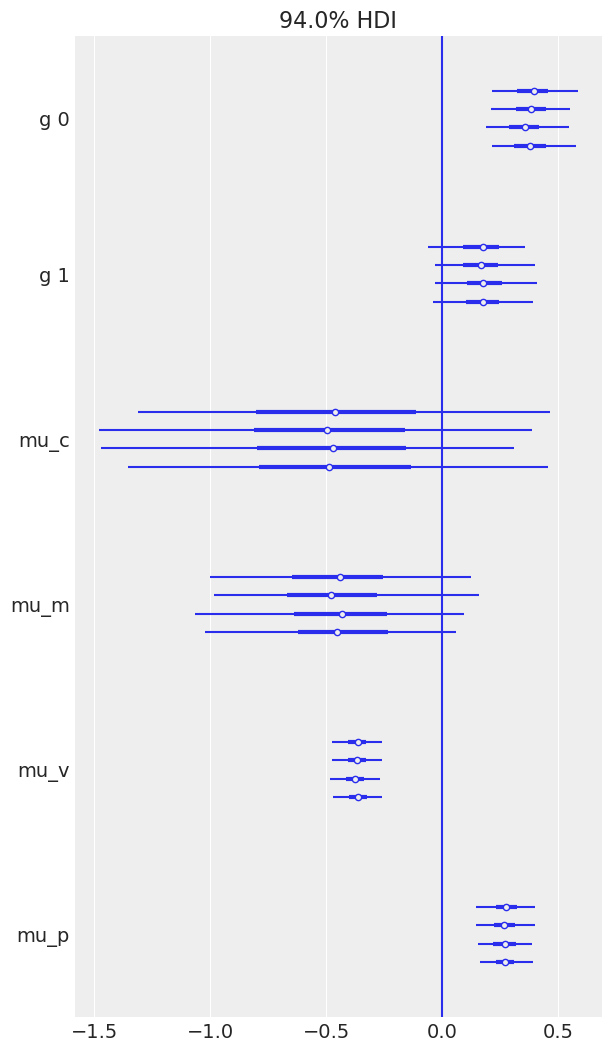

In [228]:
az.plot_forest(state_slopes_trace, var_names= ['g', 'mu_c', 'mu_m', 'mu_v', 'mu_p'])
plt.axvline(0)
plt.savefig('figs/stateForestPlot.png')
plt.show()


//mnt/D2/bbeardsall/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


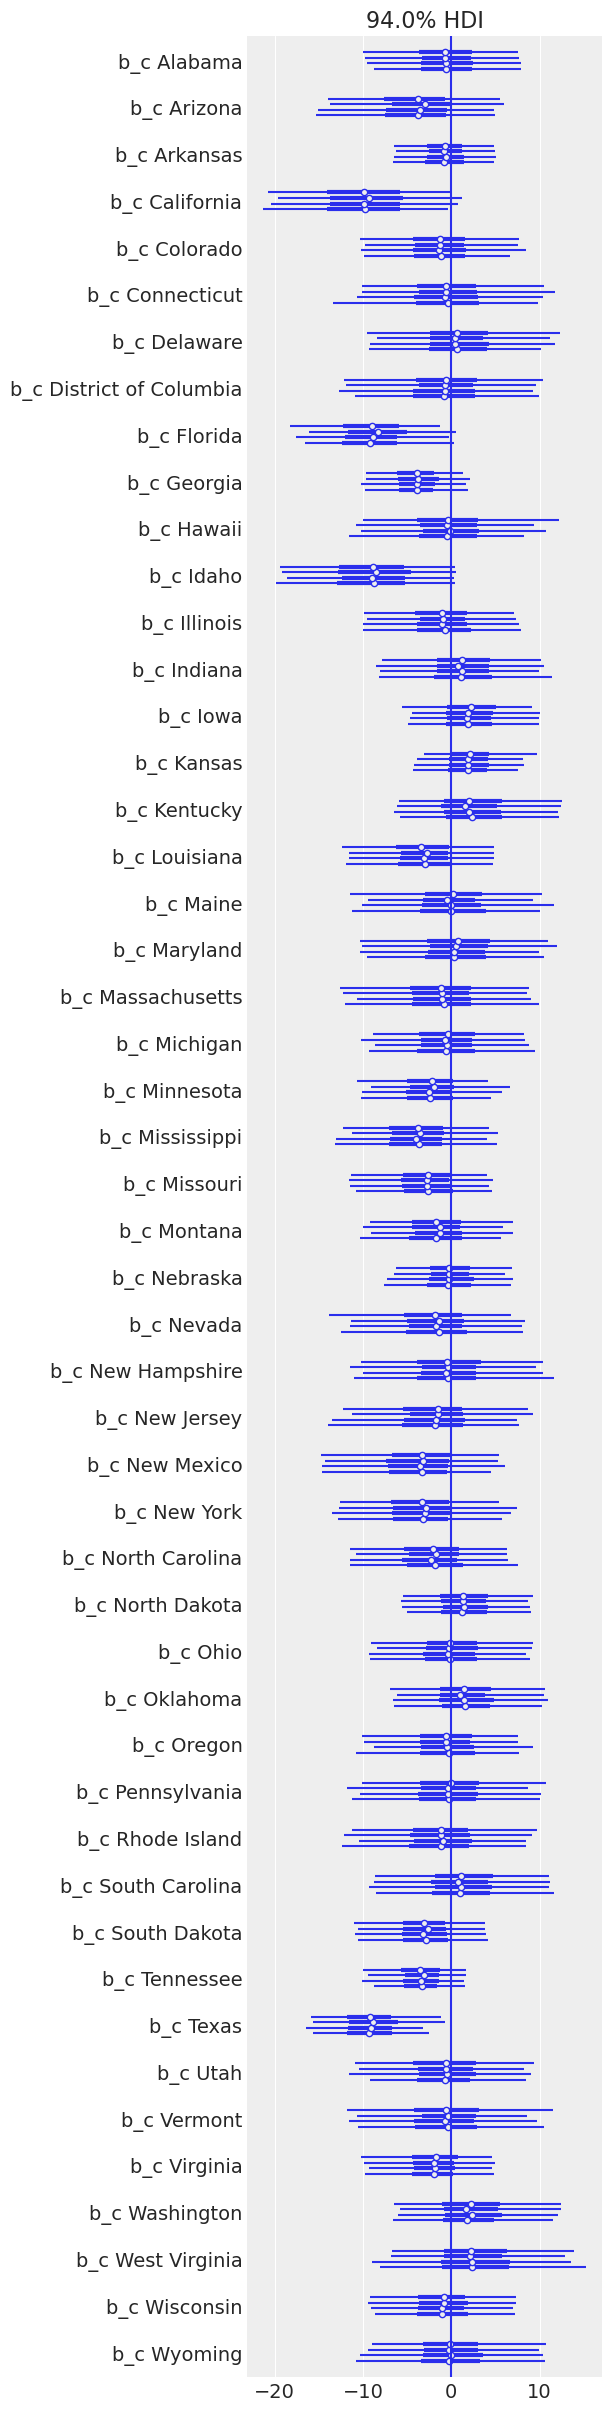

In [229]:
az.plot_forest(state_slopes_trace, var_names= 'b_c')
plt.axvline(0)
plt.savefig('figs/stateForestPlotCovidIndividStates.png')
plt.show()


# Trace plot

//mnt/D2/bbeardsall/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


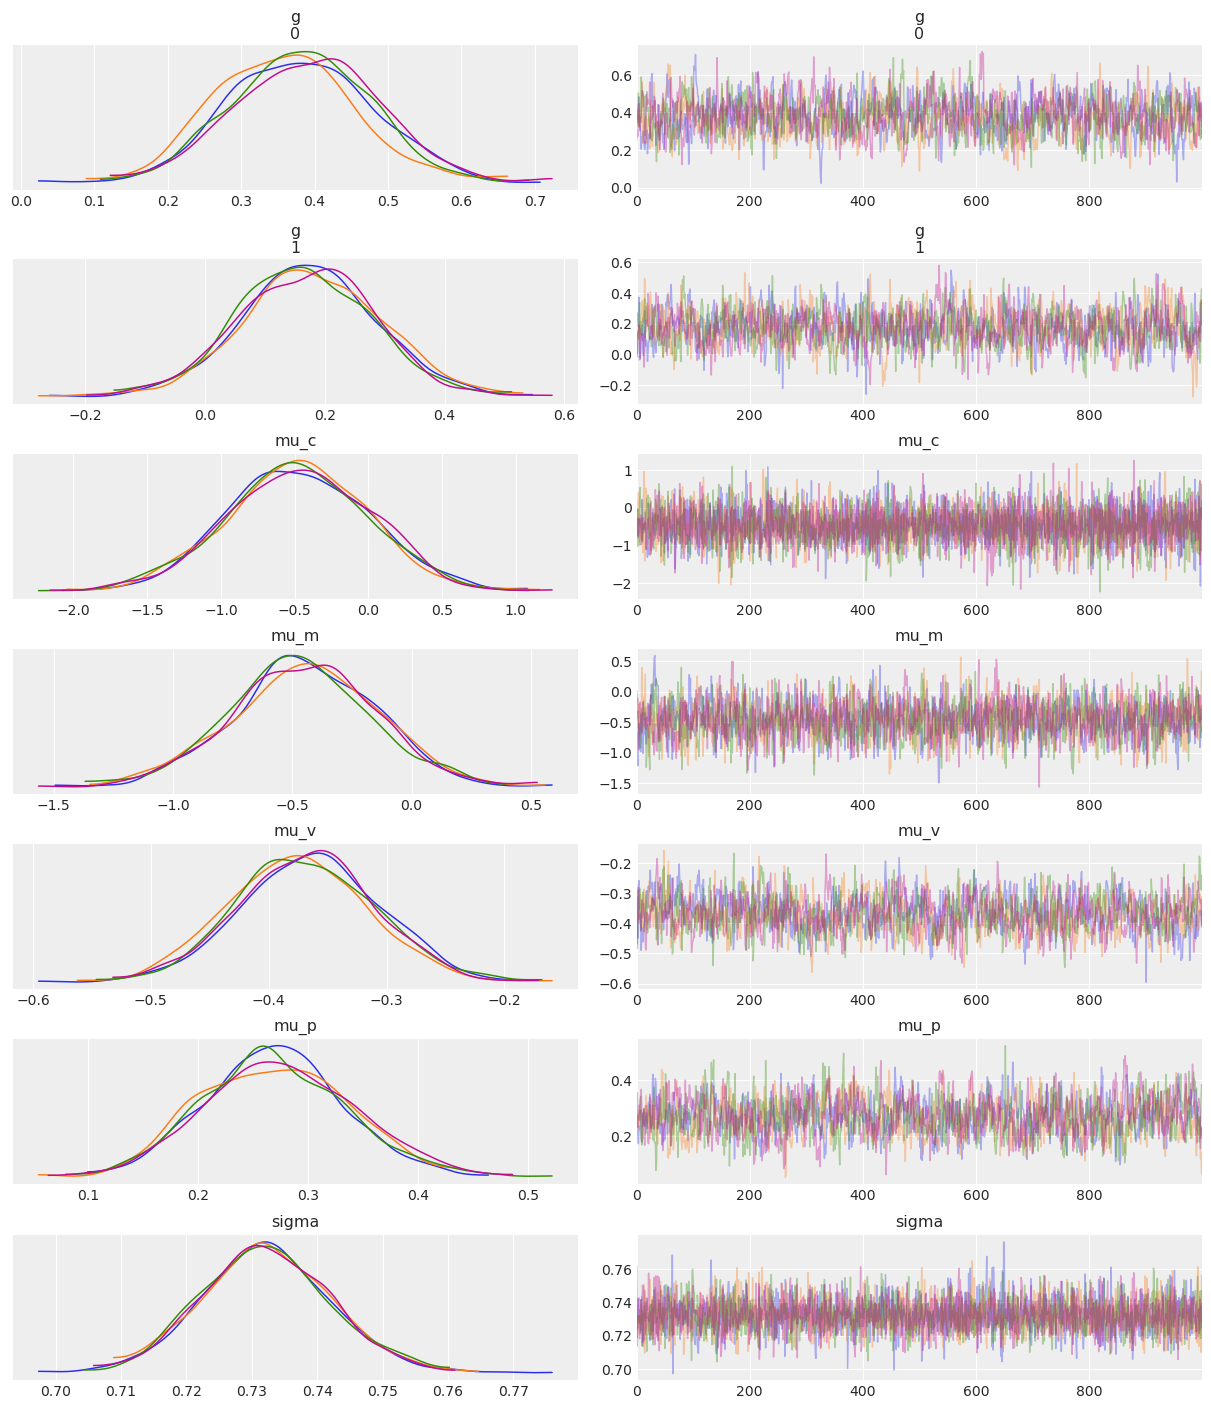

In [178]:
az.plot_trace(state_slopes_trace, var_names= ['g', 'mu_c', 'mu_m', 'mu_v', 'mu_p', 'sigma'])
plt.show()